### Classifying Breast Cancer Dataset using Variational Quantum Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from qiskit.circuit.library import ZZFeatureMap, EfficientSU2, PauliFeatureMap

from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import COBYLA
from qiskit import Aer, execute
from qiskit.aqua import QuantumInstance

import time

In [2]:
cancer = datasets.load_breast_cancer()
    
    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)
    
    # Now the dataset's features will be standardized
    # to fit a normal distribution.
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
    
    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    
n = 2

pca = PCA(n_components=n).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
samples = np.append(X_train, X_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
X_train = minmax_scale.transform(X_train)
X_test = minmax_scale.transform(X_test)

training_size = 20
test_size = 10
class_labels = [r'Benign', r'Malignant']
    # Now some sample should be picked to train the model from
training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
test_input = {key: (X_train[Y_train == k, :])[training_size:(
    training_size+test_size)] for k, key in enumerate(class_labels)}


In [3]:
training_input

{'Benign': array([[ 1.54666343e-01,  5.55981513e-01],
        [-1.59901700e-01, -4.29529264e-01],
        [-3.10571729e-01, -1.90198686e-01],
        [-1.31476605e-01, -3.94517553e-01],
        [-3.09442720e-01, -4.37714804e-01],
        [-5.74283098e-01, -3.68272133e-01],
        [-9.08218284e-02,  8.06158477e-02],
        [-8.34836357e-02, -9.56553242e-02],
        [-7.08568012e-01, -2.86698683e-01],
        [-4.00284551e-02, -3.57512836e-01],
        [-2.42542319e-01, -1.96261431e-05],
        [-2.01462863e-01, -4.01415734e-01],
        [-3.51150516e-01,  3.01688531e-03],
        [ 3.94339422e-01, -7.65699924e-01],
        [-3.05573782e-02,  7.53985894e-02],
        [ 3.63807376e-01, -1.58992983e-01],
        [ 2.88870769e-01,  3.71318425e-02],
        [-2.36300673e-01,  3.59046833e-02],
        [-4.16060955e-01, -1.60567397e-01],
        [ 8.17221789e-02, -2.91444377e-01]]),
 'Malignant': array([[-0.93682724, -0.41390706],
        [-0.55804035, -0.41478057],
        [-0.85962014, -

In [4]:
test_input

{'Benign': array([[-0.18701881, -0.05887415],
        [-0.41969524, -0.14556651],
        [-0.17530215,  0.11928263],
        [-0.11330792, -0.50174817],
        [-0.00978474, -0.40939672],
        [-0.24896605,  0.17169182],
        [-0.3616769 , -0.37676914],
        [-0.3669769 , -0.38935638],
        [-0.00982132, -0.87140379],
        [-0.16271896, -0.37946278]]),
 'Malignant': array([[-0.76691978, -0.26788732],
        [-0.83274125, -0.34036737],
        [-0.06285921,  0.6778442 ],
        [-0.70374229, -0.364161  ],
        [-0.90750905, -0.50363411],
        [-0.37930336,  0.02840254],
        [-0.73366262,  0.01485531],
        [-0.65205472, -0.06960286],
        [-0.78968096, -0.15883419],
        [-0.69868338, -0.14360801]])}

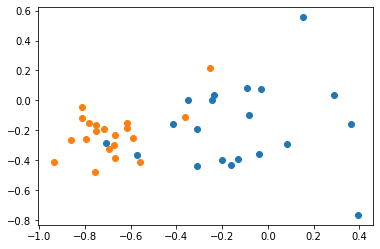

size training set: 40


In [5]:
plt.scatter(training_input['Benign'][:,0], training_input['Benign'][:,1])
plt.scatter(training_input['Malignant'][:,0], training_input['Malignant'][:,1])
plt.show()
length_data = len(training_input['Benign']) + len(training_input['Malignant'])
print("size training set: {}".format(length_data))

In [6]:
# Feature map
feature_map = PauliFeatureMap(feature_dimension=n, 
                                   reps=n, entanglement='full')
feature_map.draw()

┌───┐┌──────────────┐     »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■──»
     ├───┤├──────────────┤┌─┴─┐»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├»
     └───┘└──────────────┘└───┘»
«                                                                         ┌───┐»
«q_0: ─────────────────────────────────────────────────────────────────■──┤ H ├»
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├┤ H ├»
«     └─────────────────────────────────────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐     »
«q_0: ┤ U1(2.0*x[0]) ├──■──»
«     ├──────────────┤┌─┴─┐»
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├»
«     └──────────────┘└───┘»
«                                                                         
«q_0: ─────────────────────────────────────────────────────────────────■──
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├
«     └─────────────────────────────────────────────────────────────┘└───┘

In [7]:
var_circuit = EfficientSU2(n, entanglement='full', reps=n)  #Variational circuit
var_circuit.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├──■──┤ RY(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├┤ X ├┤ RY(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐
«q_0: ┤ RZ(θ[10]) ├
«     ├───────────┤
«q_1: ┤ RZ(θ[11]) ├
«     └───────────┘

In [8]:
cls_opt = COBYLA(maxiter=500, tol=0.001)   #classical optimizer

In [9]:
seed = 10598

# setting our backend to qasm_simulator with the "statevector" method on. This particular setup is given as it was 
# found to perform better than most. Feel free to play around with different backend options.
backend = Aer.get_backend('qasm_simulator')
backend_options = {"method": "statevector"}

# creating a quantum instance using the backend and backend options taken before
quantum_instance = QuantumInstance(backend, shots=1050, seed_simulator=seed, seed_transpiler=seed, 
                                   backend_options=backend_options)

# creating a VQC instance which you will be used for training. Make sure you input the correct training_dataset and 
# testing_dataset as defined in your program.
vqc = VQC(optimizer=cls_opt, 
          feature_map=feature_map, 
          var_form=var_circuit, 
          training_dataset=training_input,    
          test_dataset=test_input)       

In [10]:
start = time.process_time()

result = vqc.run(quantum_instance)

print("time taken: ")
print(time.process_time() - start)

print("testing success ratio: {}".format(result['testing_accuracy']))

time taken: 
47.063204001
testing success ratio: 0.75
